##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train a salad detector with TensorFlow Lite Model Maker

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/tutorials/model_maker_object_detection"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/model_maker_object_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/model_maker_object_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/tutorials/model_maker_object_detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this colab notebook, you'll learn how to use the [TensorFlow Lite Model Maker]() library to train a custom object detection model capable of detecting salads within images on a mobile device. 

The Model Maker library uses *transfer learning* to simplify the process of training a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data required and will shorten the training time.

You'll use the publicly available *Salads* dataset, which was created from the [Open Images Dataset V4](https://storage.googleapis.com/openimages/web/index.html).

Each image in the dataset contains objects labeled as one of the following classes: 
* Baked Good
* Cheese
* Salad
* Seafood
* Tomato

The dataset contains the bounding-boxes specifying where each object locates, together with the object's label. 

Here is an example image from the dataset:

<br/>

<img src="https://cloud.google.com/vision/automl/object-detection/docs/images/quickstart-preparing_a_dataset.png" width="400" hspace="0">




## Prerequisites


### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) and the pycocotools library you'll use for evaluation.

In [2]:
# TODO: change to numbered version after it's released
# !pip install -q tflite-model-maker
!pip install -q tflite-model-maker-nightly
!pip install -q pycocotools

     |████████████████████████████████| 522kB 5.9MB/s 
     |████████████████████████████████| 645kB 29.6MB/s 
     |████████████████████████████████| 133kB 33.7MB/s 
     |████████████████████████████████| 122kB 33.0MB/s 
     |████████████████████████████████| 112kB 32.9MB/s 
     |████████████████████████████████| 5.5MB 28.9MB/s 
     |████████████████████████████████| 655kB 42.2MB/s 
     |████████████████████████████████| 849kB 52.1MB/s 
     |████████████████████████████████| 1.1MB 51.3MB/s 
     |████████████████████████████████| 1.2MB 58.5MB/s 
     |████████████████████████████████| 174kB 38.9MB/s 
     |████████████████████████████████| 92kB 13.5MB/s 
     |████████████████████████████████| 358kB 53.7MB/s 
     |████████████████████████████████| 102kB 14.9MB/s 
     |████████████████████████████████| 37.6MB 78kB/s 
     |████████████████████████████████| 706kB 57.7MB/s 
     |████████████████████████████████| 194kB 59.5MB/s 


Import the required packages.

In [3]:
import numpy as np
import os

from tflite_model_maker import configs
from tflite_model_maker import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector
from tflite_model_maker import ObjectDetectorDataloader

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

### Prepare the dataset

Here you'll use the same dataset as the AutoML [quickstart](https://cloud.google.com/vision/automl/object-detection/docs/edge-quickstart#preparing_a_dataset). 

The *Salads* dataset is available at:
 `gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv.` 

It contains 175 images for training, 25 images for validation, and 25 images for testing. The dataset has five classes: `Salad`, `Seafood`, `Tomato`, `Baked goods`, `Cheese`.

<br/>

The dataset is provided in CSV format:
```
TRAINING,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Salad,0.0,0.0954,,,0.977,0.957,,
VALIDATION,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Seafood,0.0154,0.1538,,,1.0,0.802,,
TEST,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Tomato,0.0,0.655,,,0.231,0.839,,
```

* Each row corresponds to an object localized inside a larger image, with each object specifically designated as test, train, or validation data. You'll learn more about what that means in a later stage in this notebook.
* The three lines included here indicate **three distinct objects located inside the same image** available at `gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg`.
* Each row has a different label: `Salad`, `Seafood`, `Tomato`, etc.
* Bounding boxes are specified for each image using the top left and bottom right vertices.

Here is a visualzation of these three lines:

<br>

<img src="https://cloud.google.com/vision/automl/object-detection/docs/images/quickstart-preparing_a_dataset.png" width="400" hspace="100">

If you want to know more about how to prepare your own CSV file and the minimum requirements for creating a valid dataset, see the [Preparing your training data](https://cloud.google.com/vision/automl/object-detection/docs/prepare) guide for more details.

If you are new to Google Cloud, you may wonder what the `gs://` URL means. They are URLs of files stored on [Google Cloud Storage](https://cloud.google.com/storage) (GCS). If you make your files on GCS public or [authenticate your client](https://cloud.google.com/storage/docs/authentication#libauth), Model Maker can read those files similarly to your local files. 

However, you don't need to keep your images on Google Cloud to use Model Maker. You can use a local path in your CSV file and Model Maker will just work.

## Train your salad detection model

There are five steps to training an object detection model:

**Step 1. Choose an object detection model archiecture.**

This tutorial uses the EfficientDet-Lite2 model. EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture. 

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 37            | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 49            | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 69            | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 116           | 37.70%               |
| EfficientDet-Lite4 | 19.5      | 158           | 39.05%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Pixel 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>


In [4]:
spec = model_spec.get('efficientdet_lite2')

**Step 2. Load the dataset.**

Model Maker will take input data in the CSV format. Use the `ObjectDetectorDataloader.from_csv` method to load the dataset and split them into the training, validation and test images.

* Training images: These images are used to train the object detection model to recognize salad ingredients.
* Validation images: These are images that the model didn't see during the training process. You'll use them to decide when you should stop the training, to avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting).
* Test images: These images are used to evaluate the final model performance.

You can load the CSV file directly from Google Cloud Storage, but you don't need to keep your images on Google Cloud to use Model Maker. You can specify a local CSV file on your computer, and Model Maker will work just fine.

In [5]:
train_data, validation_data, test_data = ObjectDetectorDataloader.from_csv('gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv')

**Step 3. Train the TensorFlow model with the training data.**

* The EfficientDet-Lite0 model uses `epochs = 50` by default, which means it will go through the training dataset 50 times. You can look at the validation accuracy during training and stop early to avoid overfitting.
* Set `batch_size = 8` here so you will see that it takes 21 steps to go through the 175 images in the training dataset. 
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [6]:
model = object_detector.create(train_data, model_spec=spec, batch_size=8, train_whole_model=True, validation_data=validation_data)

Epoch 1/50
21/21 [==============================] - 103s 2s/step - det_loss: 1.7293 - cls_loss: 1.1323 - box_loss: 0.0119 - reg_l2_loss: 0.0764 - loss: 1.8058 - learning_rate: 0.0090 - gradient_norm: 0.6928 - val_det_loss: 1.6635 - val_cls_loss: 1.1057 - val_box_loss: 0.0112 - val_reg_l2_loss: 0.0764 - val_loss: 1.7399

Epoch 00001: saving model to /tmp/tmpxqqfo4vc/ckpt-1
Epoch 2/50
21/21 [==============================] - 31s 1s/step - det_loss: 1.5695 - cls_loss: 1.0695 - box_loss: 0.0100 - reg_l2_loss: 0.0764 - loss: 1.6460 - learning_rate: 0.0100 - gradient_norm: 1.0612 - val_det_loss: 1.5044 - val_cls_loss: 0.9750 - val_box_loss: 0.0106 - val_reg_l2_loss: 0.0764 - val_loss: 1.5808

Epoch 00002: saving model to /tmp/tmpxqqfo4vc/ckpt-2
Epoch 3/50
21/21 [==============================] - 31s 2s/step - det_loss: 1.3908 - cls_loss: 0.9372 - box_loss: 0.0091 - reg_l2_loss: 0.0764 - loss: 1.4672 - learning_rate: 0.0099 - gradient_norm: 1.7581 - val_det_loss: 1.2524 - val_cls_loss: 0.7776

**Step 4. Evaluate the model with the test data.**

After training the object detection model using the images in the training dataset, use the remaining 25 images in the test dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 1 step to go through the 25 images in the test dataset.

In [7]:
model.evaluate(test_data)

0/1 [..............................] - ETA: 0sloading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(2500, 7)
0/2500
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.30s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.425
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.225
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

{'AP': 0.2261604,
 'AP50': 0.39270866,
 'AP75': 0.2244715,
 'AP_/Baked Goods': 0.043529555,
 'AP_/Cheese': 0.24574718,
 'AP_/Salad': 0.56715864,
 'AP_/Seafood': 0.0053153047,
 'AP_/Tomato': 0.26905137,
 'APl': 0.22491077,
 'APm': 0.42489964,
 'APs': -1.0,
 'ARl': 0.4084798,
 'ARm': 0.60833335,
 'ARmax1': 0.16366756,
 'ARmax10': 0.36524844,
 'ARmax100': 0.41107622,
 'ARs': -1.0}

In [8]:
model.export(export_dir='.', export_format=[ExportFormat.LABEL, ExportFormat.TFLITE])

**Step 6.  Evaluate the TensorFlow Lite model.**

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop. 
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [9]:
model.evaluate_tflite('model.tflite', test_data)

24/25 [===========================>..] - ETA: 7s loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(625, 7)
0/625
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.197
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.142
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

{'AP': 0.19971715,
 'AP50': 0.34896597,
 'AP75': 0.21181512,
 'AP_/Baked Goods': 0.042462554,
 'AP_/Cheese': 0.233117,
 'AP_/Salad': 0.4932866,
 'AP_/Seafood': 0.0,
 'AP_/Tomato': 0.22971961,
 'APl': 0.1967902,
 'APm': 0.44109166,
 'APs': -1.0,
 'ARl': 0.29199496,
 'ARm': 0.53333336,
 'ARmax1': 0.14186831,
 'ARmax10': 0.2786085,
 'ARmax100': 0.29662323,
 'ARs': -1.0}

You can download the TensorFlow Lite model file using the left sidebar of Colab. Right-click the `model.tflite` file and choose `Download` to download it to your local computer.

In the next step of the codelab, you'll use the [ObjectDetector API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) of the [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview) to integrate the model into the Android app.

## (Optional) Test the TFLite model on your image

You can test the trained TFLite model using images from the internet. 
* Replace the `INPUT_IMAGE_URL` below with your desired input image. 
* Adjust the `DETECTION_THRESHOLD` to change the sensitivity of the model. A lower threshold means the model will pickup more objects but there will also be more false detection. Meanwhile, a higher threshold means the model will only pickup objects that it has confidently detected.

Although it requires some of boilerplate code to run the model in Python at this moment, integrating the model into a mobile app only requires a few lines of code.

In [10]:
#@title Load the trained TFLite model and define some visualization functions

import cv2

from PIL import Image

model_path = 'model.tflite'
label_map_path = 'labels.txt'

# Load the labels into a list
with open(label_map_path, 'r') as f:
  classes = f.read().splitlines()

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path, 
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute 
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

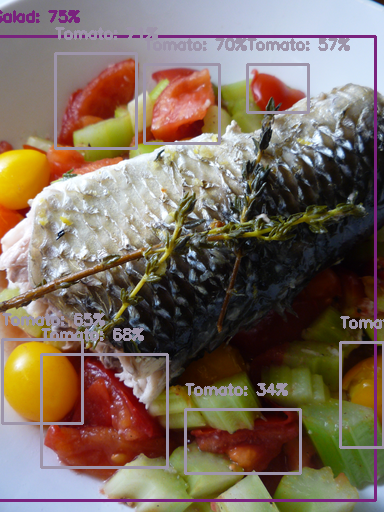

In [11]:
#@title Run object detection and show the detection results

INPUT_IMAGE_URL = "https://storage.googleapis.com/cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.3 #@param {type:"number"}

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE, 
    interpreter, 
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)